<h1 align=center><font size = 5>Optimization of Automated Teller Machines (ATMs) Locations using Location data and K-Means Clustering.</font></h1>

## Introduction

The Economist Intelligence Unit is a research and analysis division of The Economist Group providing forecasting and advisory services through research and analysis, such as monthly country reports, five-year country economic forecasting, country risk service reports and industry reports. Recently, the Economist Intelligence Unit released its “Global Liveability report” which ranked three of Canada’s cities among the top 10. These were Toronto, Vancouver and Calgary. 

These cities were recognised as being some of the most welcoming cities with a strong intercultural population. With their thriving cultural services, restaurants, recreational facilities, stable economy, excellent health care, etc. All these are conditions that are very favourable for a variety of institutions. For example, financial institutions.

In this lab, I explored, segmented and clustered the neighbourhoods in Vancouver to make a recommendation for the optimum location for ATM placement. 

For the neighbourhood data for this city, a wikipedia page exits that has all the information needed to explore and cluster the neighbourhoods in Vancouver. I scraped the Wikipedia page and wrangled the data, cleaned it, and then read it into a pandas dataframe so that it was in a structured format.

Once the data was in a structured format, I explored and clustered the neighbourhoods in vancouver.

## Problem

Financial service industries face increased regulations and disruption from new technology. Banks and financial institutions that want to maintain their competitive edge need to leverage location data. If retail banks are not able to meet these expectations, they will be left behind in this fast-paced industry. In order to provide the best user experience for their customers, one consideration could be the strategic placement of Automated Teller Machines (ATMs). Too many ATMs at one location can drive up operational costs, while too few limits the ability to provide adequate service to customers in the area.


## Data Description 

To consider the problem we can list the data as below;
•	For the neighbourhood data on Vancouver, I used an overview of boroughs, postal codes and neighbourhood data of the city found on Wikipedia.
•	I used Foursquare API to get the most trending venues or areas with the most foot traffic (Train Stations, Gas Stations, Supermarkets and malls) given the boroughs of Vancouver.
•	I used Geopy to geocoding my data.
•	K-Means Clustering Algorithm.


## Methodology

Before getting the data and start exploring it, I downloaded all the dependencies that will be needed.

In [1]:
# library to handle data in a vectorized manner
import numpy as np 

# library for data analsysis
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json 

# convert an address into latitude and longitude values
!pip install geopy 
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!pip install folium 
import folium 

# library for web scraping
!pip install beautifulsoup4 
from bs4 import BeautifulSoup
!pip install lxml

#library for geospatial data
!pip install geocoder

!pip install regex

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 6.2 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/

## 1. Scrape data from website and transform into pandas dataframe

In this section, I built the code to scrape the Wikipedia page in order to obtain the data that is in the table of postal codes and transformed the data into a pandas dataframe.

##### Vancouver Postal Codes

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V"

html_contents = requests.get(url).text

soup = BeautifulSoup(html_contents, "lxml")


In [3]:
tab = soup.find_all('div', id = 'mw-content-text')

for rows in tab:
    data = rows.find('tbody').text

with open ('html2', 'a') as f:
    f.write(str(data))

f = open("html2", "r")
 

a_file = open("html2", "r")

van_list_of_lists = [(line.strip()).split() for line in a_file]

a_file.close()



van_list = [x for x in van_list_of_lists if x != []]

After successfully scraping the web, I transformed the data into a dataframe and added two emptpy columns for the Latitude and Longitude

In [4]:
v_df=pd.DataFrame(van_list)
v_df['Postal Code'] = v_df[0].str[0:3]
v_df['tst'] = v_df[0].str[3:] + v_df[1]
v_df[['Borough','hood']] = v_df['tst'].str.split('(',n=1, expand=True)
v_df["hood2"] = v_df["hood"].str.cat(v_df[[2,3,4,5,6,7,8,9,10,11,12,13,14]].astype(str))
v_df[['Neighborhood','None']] = v_df['hood2'].str.split(')',n=1, expand=True)
v_postcode_df = v_df[['Postal Code', 'Borough', 'Neighborhood']]
v_postcode_df = v_postcode_df.dropna()
v_postcode_df['Neighborhood'] = v_postcode_df['Neighborhood'].str.replace('/',', ')
vancouver_df = v_postcode_df[v_postcode_df['Borough'].str.contains("Vancouver")].reset_index(drop=True)
vancouver_df['Latitude'] = ""
vancouver_df['Longitude'] = ""

vancouver_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,V6A,Vancouver,"Strathcona, Chinatown, DowntownEastside",,
1,V6B,Vancouver,"NEDowntown, Gastown, HarbourCentre, Internatio...",,
2,V6C,Vancouver,"Waterfront, CoalHarbour, CanadaPlace",,
3,V6E,Vancouver,"SEWestEnd, DavieVillage",,
4,V6G,Vancouver,"NWWestEnd, StanleyPark",,


Using Nominatim, I fetched the Latitude and Longitude values for the respective boroughs

In [5]:
geolocator = Nominatim(user_agent='vancou')

for i in vancouver_df.index:
    try:
        location = geolocator.geocode(vancouver_df['Postal Code'][i])
        
        vancouver_df.loc[i,'Latitude'] = location.latitude
        vancouver_df.loc[i,'Longitude'] = location.longitude
    except:
        vancouver_df.loc[i,'Latitude'] = ''
        vancouver_df.loc[i,'Longitude'] = ''
        
vancouver_df.head()        

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,V6A,Vancouver,"Strathcona, Chinatown, DowntownEastside",49.2738,-123.099
1,V6B,Vancouver,"NEDowntown, Gastown, HarbourCentre, Internatio...",49.2781,-123.12
2,V6C,Vancouver,"Waterfront, CoalHarbour, CanadaPlace",49.2877,-123.115
3,V6E,Vancouver,"SEWestEnd, DavieVillage",49.288,-123.121
4,V6G,Vancouver,"NWWestEnd, StanleyPark",49.3003,-123.138


Further cleaning of the data frame

In [6]:
vancouver_df = vancouver_df[vancouver_df.Latitude != 'Not assigned']
vancouver_df = vancouver_df[vancouver_df.Latitude != '']
vancouver_df = vancouver_df.astype({"Latitude": float, "Longitude": float})
vancouver_df['Neighborhood'] = vancouver_df['Neighborhood'].str.replace(r'(\w)([A-Z])', r'\1 \2')
vancouver_df['Neighborhood'] = vancouver_df['Neighborhood'].str.replace(r'(\w)([A-Z])', r'\1 \2')

vancouver_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",49.273770,-123.099479
1,V6B,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",49.278112,-123.119598
2,V6C,Vancouver,"Waterfront, Coal Harbour, Canada Place",49.287717,-123.115194
3,V6E,Vancouver,"S E West End, Davie Village",49.288013,-123.121081
4,V6G,Vancouver,"N W West End, Stanley Park",49.300270,-123.137797


I used the following code to get the geographical coordinates of Toronto.

In [7]:
address = 'Vancouver, VAN'

geolocator = Nominatim(user_agent="van_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


I used the following code to visualize the Neighborhoods in Vancouver.

In [8]:
map_vancouver = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(vancouver_df['Latitude'], vancouver_df['Longitude'], vancouver_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

Next, i used the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [9]:
# The code was removed by Watson Studio for sharing.

Used the 'ATM' search query to find all ATMs in a defined radius

In [10]:
search_query = 'ATM'
radius = 50000
print(search_query + ' .... OK!')

ATM .... OK!


I created the GET request URL.

In [11]:
# The code was removed by Watson Studio for sharing.

Sent the GET request and examined the resutls

In [12]:
van_results = requests.get(url2).json()

Transformed JSON file to a data frame

In [13]:
# assign relevant part of JSON to venues
van_venues = van_results['response']['venues']

# tranform venues into a dataframe
van_dataframe = json_normalize(van_venues)
van_dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,5cf531ed35811b002c5c7ed9,President's Choice Financial ATM,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",v-1617795588,False,885 West BRdway,49.263626,-123.123586,"[{'label': 'display', 'lat': 49.263626, 'lng':...",763,V5Z 1J9,CA,Vancouver,BC,Canada,"[885 West BRdway, Vancouver BC V5Z 1J9, Canada]",NaN,NaN
1,5cf531aa3fcee8002c55417f,President's Choice Financial ATM,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",v-1617795588,False,370 East Broadway,49.262349,-123.097121,"[{'label': 'display', 'lat': 49.262349, 'lng':...",1233,V5T 4G5,CA,Vancouver,BC,Canada,"[370 East Broadway, Vancouver BC V5T 4G5, Canada]",NaN,NaN
2,5cf530c59de23b002c3c5d7e,President's Choice Financial ATM,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",v-1617795588,False,2888 Granville St,49.259957,-123.138272,"[{'label': 'display', 'lat': 49.259957, 'lng':...",1769,V6H 3J5,CA,Vancouver,BC,Canada,"[2888 Granville St, Vancouver BC V6H 3J5, Canada]",NaN,NaN
3,5cf533803731ee002ca6617e,President's Choice Financial ATM,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",v-1617795588,False,1006 Homer St,49.277040,-123.120025,"[{'label': 'display', 'lat': 49.27704, 'lng': ...",1853,V6B 2W9,CA,Vancouver,BC,Canada,"[1006 Homer St, Vancouver BC V6B 2W9, Canada]",NaN,NaN
4,5cfe224dbfc6d0002cf2ca69,President's Choice Financial ATM,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",v-1617795588,False,1780 West BRdway,49.263542,-123.144703,"[{'label': 'display', 'lat': 49.263542, 'lng':...",2253,V6J 1Y1,CA,Vancouver,BC,Canada,"[1780 West BRdway, Vancouver BC V6J 1Y1, Canada]",NaN,NaN


Cleaned data frame

In [14]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in van_dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = van_dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,President's Choice Financial ATM,ATM,885 West BRdway,49.263626,-123.123586,"[{'label': 'display', 'lat': 49.263626, 'lng':...",763,V5Z 1J9,CA,Vancouver,BC,Canada,"[885 West BRdway, Vancouver BC V5Z 1J9, Canada]",NaN,NaN,5cf531ed35811b002c5c7ed9
1,President's Choice Financial ATM,ATM,370 East Broadway,49.262349,-123.097121,"[{'label': 'display', 'lat': 49.262349, 'lng':...",1233,V5T 4G5,CA,Vancouver,BC,Canada,"[370 East Broadway, Vancouver BC V5T 4G5, Canada]",NaN,NaN,5cf531aa3fcee8002c55417f
2,President's Choice Financial ATM,ATM,2888 Granville St,49.259957,-123.138272,"[{'label': 'display', 'lat': 49.259957, 'lng':...",1769,V6H 3J5,CA,Vancouver,BC,Canada,"[2888 Granville St, Vancouver BC V6H 3J5, Canada]",NaN,NaN,5cf530c59de23b002c3c5d7e
3,President's Choice Financial ATM,ATM,1006 Homer St,49.277040,-123.120025,"[{'label': 'display', 'lat': 49.27704, 'lng': ...",1853,V6B 2W9,CA,Vancouver,BC,Canada,"[1006 Homer St, Vancouver BC V6B 2W9, Canada]",NaN,NaN,5cf533803731ee002ca6617e
4,President's Choice Financial ATM,ATM,1780 West BRdway,49.263542,-123.144703,"[{'label': 'display', 'lat': 49.263542, 'lng':...",2253,V6J 1Y1,CA,Vancouver,BC,Canada,"[1780 West BRdway, Vancouver BC V6J 1Y1, Canada]",NaN,NaN,5cfe224dbfc6d0002cf2ca69


Renamed all category names to 'ATM'

In [15]:
dataframe_filtered['categories'] = 'ATM'

Checked to see if code was executed successfully

In [16]:
dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,President's Choice Financial ATM,ATM,885 West BRdway,49.263626,-123.123586,"[{'label': 'display', 'lat': 49.263626, 'lng':...",763,V5Z 1J9,CA,Vancouver,BC,Canada,"[885 West BRdway, Vancouver BC V5Z 1J9, Canada]",NaN,NaN,5cf531ed35811b002c5c7ed9
1,President's Choice Financial ATM,ATM,370 East Broadway,49.262349,-123.097121,"[{'label': 'display', 'lat': 49.262349, 'lng':...",1233,V5T 4G5,CA,Vancouver,BC,Canada,"[370 East Broadway, Vancouver BC V5T 4G5, Canada]",NaN,NaN,5cf531aa3fcee8002c55417f
2,President's Choice Financial ATM,ATM,2888 Granville St,49.259957,-123.138272,"[{'label': 'display', 'lat': 49.259957, 'lng':...",1769,V6H 3J5,CA,Vancouver,BC,Canada,"[2888 Granville St, Vancouver BC V6H 3J5, Canada]",NaN,NaN,5cf530c59de23b002c3c5d7e
3,President's Choice Financial ATM,ATM,1006 Homer St,49.277040,-123.120025,"[{'label': 'display', 'lat': 49.27704, 'lng': ...",1853,V6B 2W9,CA,Vancouver,BC,Canada,"[1006 Homer St, Vancouver BC V6B 2W9, Canada]",NaN,NaN,5cf533803731ee002ca6617e
4,President's Choice Financial ATM,ATM,1780 West BRdway,49.263542,-123.144703,"[{'label': 'display', 'lat': 49.263542, 'lng':...",2253,V6J 1Y1,CA,Vancouver,BC,Canada,"[1780 West BRdway, Vancouver BC V6J 1Y1, Canada]",NaN,NaN,5cfe224dbfc6d0002cf2ca69


I used the following code to visualize the ATM locations in Vancouver.

In [17]:
ATM_map = folium.Map(location=[49.2608724,-123.1139529], zoom_start=11) # generate map centred around the Conrad Hotel



# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(ATM_map)

# display map
ATM_map

#### Repeated the same process for the train station as well

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
search_query = 'Train Station'
radius = 10000
print(search_query + ' .... OK!')

Train Station .... OK!


In [20]:
# The code was removed by Watson Studio for sharing.

In [21]:
ts_results = requests.get(url3).json()


In [22]:
# assign relevant part of JSON to venues
ts_venues = ts_results['response']['venues']

# tranform venues into a dataframe
ts_dataframe = json_normalize(ts_venues)
ts_dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,4aa7ca83f964a520364d20e3,Broadway - City Hall SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795588,False,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN
1,4aac3fd8f964a5201d5d20e3,Yaletown - Roundhouse SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795588,False,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN
2,4aa921eaf964a5201d5220e3,Olympic Village SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795588,False,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview
3,4ab9527bf964a520f17e20e3,Stadium - Chinatown SkyTrain Station,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1617795588,False,590 Beatty St,at Dunsmuir St,49.279267,-123.109447,NaN,2073,NaN,CA,Vancouver,BC,Canada,"[590 Beatty St (at Dunsmuir St), Vancouver BC,...",NaN
4,4ab951f2f964a520ee7e20e3,Main Street – Science World SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795588,False,Main St,at Terminal Ave,49.273079,-123.100360,"[{'label': 'display', 'lat': 49.27307872863681...",1679,NaN,CA,Vancouver,BC,Canada,"[Main St (at Terminal Ave), Vancouver BC, Canada]",NaN


In [23]:
# keep only columns that include venue name, and anything that is associated with location
ts_filtered_columns = ['name', 'categories'] + [col for col in ts_dataframe.columns if col.startswith('location.')] + ['id']
ts_dataframe_filtered = ts_dataframe.loc[:, ts_filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
ts_dataframe_filtered['categories'] = ts_dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
ts_dataframe_filtered.columns = [column.split('.')[-1] for column in ts_dataframe_filtered.columns]

ts_dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Broadway - City Hall SkyTrain Station,Light Rail Station,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN,4aa7ca83f964a520364d20e3
1,Yaletown - Roundhouse SkyTrain Station,Light Rail Station,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN,4aac3fd8f964a5201d5d20e3
2,Olympic Village SkyTrain Station,Light Rail Station,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview,4aa921eaf964a5201d5220e3
3,Stadium - Chinatown SkyTrain Station,Metro Station,590 Beatty St,at Dunsmuir St,49.279267,-123.109447,NaN,2073,NaN,CA,Vancouver,BC,Canada,"[590 Beatty St (at Dunsmuir St), Vancouver BC,...",NaN,4ab9527bf964a520f17e20e3
4,Main Street – Science World SkyTrain Station,Light Rail Station,Main St,at Terminal Ave,49.273079,-123.100360,"[{'label': 'display', 'lat': 49.27307872863681...",1679,NaN,CA,Vancouver,BC,Canada,"[Main St (at Terminal Ave), Vancouver BC, Canada]",NaN,4ab951f2f964a520ee7e20e3


In [24]:
ts_dataframe_filtered['categories'] = 'Train Station'

In [25]:
venues_map2 = folium.Map(location=[49.2608724,-123.1139529], zoom_start=11) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(ts_dataframe_filtered.lat, ts_dataframe_filtered.lng, ts_dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map2)

    
# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map2)
# display map
venues_map2

#### Repeated the same process for the gas station as well

In [26]:
# The code was removed by Watson Studio for sharing.

In [27]:
search_query = 'Gas Station'
radius = 10000
print(search_query + ' .... OK!')

Gas Station .... OK!


In [28]:
# The code was removed by Watson Studio for sharing.

In [29]:
gs_results = requests.get(url4).json()


In [30]:
# assign relevant part of JSON to venues
gs_venues = gs_results['response']['venues']

# tranform venues into a dataframe
gs_dataframe = json_normalize(gs_venues)
gs_dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id
0,4aa7ca83f964a520364d20e3,Broadway - City Hall SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795589,False,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN,NaN
1,4aac3fd8f964a5201d5d20e3,Yaletown - Roundhouse SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795589,False,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN,NaN
2,5ede0fea90354b4076d0ed22,Total Service Quality Plumbing & Gas,"[{'id': '5454144b498ec1f095bff2f2', 'name': 'C...",v-1617795589,False,2633 Birch St,NaN,49.262316,-123.115926,"[{'label': 'display', 'lat': 49.26231559749254...",215,V2S 4J1,CA,Abbotsford,BC,Canada,"[2633 Birch St, Abbotsford BC V2S 4J1, Canada]",NaN,NaN
3,4aa921eaf964a5201d5220e3,Olympic Village SkyTrain Station,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1617795589,False,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview,NaN
4,4aa7536ef964a520b44c20e3,Pacific Central Station (XEA),"[{'id': '4bf58dd8d48988d129951735', 'name': 'T...",v-1617795589,False,1150 Station St,at Terminal Ave,49.273568,-123.097901,NaN,1832,V6A 4C7,CA,Vancouver,BC,Canada,"[1150 Station St (at Terminal Ave), Vancouver ...",NaN,NaN


In [31]:
# keep only columns that include venue name, and anything that is associated with location
gs_filtered_columns = ['name', 'categories'] + [col for col in gs_dataframe.columns if col.startswith('location.')] + ['id']
gs_dataframe_filtered = gs_dataframe.loc[:, gs_filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
gs_dataframe_filtered['categories'] = gs_dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
gs_dataframe_filtered.columns = [column.split('.')[-1] for column in gs_dataframe_filtered.columns]

gs_dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Broadway - City Hall SkyTrain Station,Light Rail Station,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN,4aa7ca83f964a520364d20e3
1,Yaletown - Roundhouse SkyTrain Station,Light Rail Station,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN,4aac3fd8f964a5201d5d20e3
2,Total Service Quality Plumbing & Gas,Construction & Landscaping,2633 Birch St,NaN,49.262316,-123.115926,"[{'label': 'display', 'lat': 49.26231559749254...",215,V2S 4J1,CA,Abbotsford,BC,Canada,"[2633 Birch St, Abbotsford BC V2S 4J1, Canada]",NaN,5ede0fea90354b4076d0ed22
3,Olympic Village SkyTrain Station,Light Rail Station,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview,4aa921eaf964a5201d5220e3
4,Pacific Central Station (XEA),Train Station,1150 Station St,at Terminal Ave,49.273568,-123.097901,NaN,1832,V6A 4C7,CA,Vancouver,BC,Canada,"[1150 Station St (at Terminal Ave), Vancouver ...",NaN,4aa7536ef964a520b44c20e3


In [32]:
gs_dataframe_filtered['categories'] = 'Gas Station'
gs_dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Broadway - City Hall SkyTrain Station,Gas Station,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN,4aa7ca83f964a520364d20e3
1,Yaletown - Roundhouse SkyTrain Station,Gas Station,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN,4aac3fd8f964a5201d5d20e3
2,Total Service Quality Plumbing & Gas,Gas Station,2633 Birch St,NaN,49.262316,-123.115926,"[{'label': 'display', 'lat': 49.26231559749254...",215,V2S 4J1,CA,Abbotsford,BC,Canada,"[2633 Birch St, Abbotsford BC V2S 4J1, Canada]",NaN,5ede0fea90354b4076d0ed22
3,Olympic Village SkyTrain Station,Gas Station,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview,4aa921eaf964a5201d5220e3
4,Pacific Central Station (XEA),Gas Station,1150 Station St,at Terminal Ave,49.273568,-123.097901,NaN,1832,V6A 4C7,CA,Vancouver,BC,Canada,"[1150 Station St (at Terminal Ave), Vancouver ...",NaN,4aa7536ef964a520b44c20e3


In [33]:
ts_dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Broadway - City Hall SkyTrain Station,Train Station,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN,4aa7ca83f964a520364d20e3
1,Yaletown - Roundhouse SkyTrain Station,Train Station,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN,4aac3fd8f964a5201d5d20e3
2,Olympic Village SkyTrain Station,Train Station,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview,4aa921eaf964a5201d5220e3
3,Stadium - Chinatown SkyTrain Station,Train Station,590 Beatty St,at Dunsmuir St,49.279267,-123.109447,NaN,2073,NaN,CA,Vancouver,BC,Canada,"[590 Beatty St (at Dunsmuir St), Vancouver BC,...",NaN,4ab9527bf964a520f17e20e3
4,Main Street – Science World SkyTrain Station,Train Station,Main St,at Terminal Ave,49.273079,-123.100360,"[{'label': 'display', 'lat': 49.27307872863681...",1679,NaN,CA,Vancouver,BC,Canada,"[Main St (at Terminal Ave), Vancouver BC, Canada]",NaN,4ab951f2f964a520ee7e20e3


#### Repeated the same process for the supermarkets as well

In [34]:
# The code was removed by Watson Studio for sharing.

In [35]:
search_query = 'Supermarket'
radius = 10000
print(search_query + ' .... OK!')

Supermarket .... OK!


In [36]:
# The code was removed by Watson Studio for sharing.

In [37]:
sm_results = requests.get(url5).json()


In [38]:
# assign relevant part of JSON to venues
sm_venues = sm_results['response']['venues']

# tranform venues into a dataframe
sm_dataframe = json_normalize(sm_venues)
sm_dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,4aa84d2ff964a520b65020e3,T&T Supermarket,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1617795589,False,179 Keefer Pl,at Abbott St,49.279907,-123.107992,"[{'label': 'display', 'lat': 49.27990675657744...",2162,V6B 0J1,CA,Vancouver,BC,Canada,"[179 Keefer Pl (at Abbott St), Vancouver BC V6...",NaN
1,4b4b80e4f964a5204f9e26e3,T&T Supermarket,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1617795589,False,#100-2800 E. 1st Ave.,at Renfrew St.,49.269098,-123.046049,"[{'label': 'display', 'lat': 49.26909769091307...",5016,V5M 4N8,CA,Vancouver,BC,Canada,"[#100-2800 E. 1st Ave. (at Renfrew St.), Vanco...",NaN
2,4b243abcf964a520396424e3,Chinatown Supermarket Inc,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1617795589,False,239 Keefer St.,btw Main St. & Gore Ave.,49.279522,-123.098504,"[{'label': 'display', 'lat': 49.279522, 'lng':...",2359,V6A 1X6,CA,Vancouver,BC,Canada,"[239 Keefer St. (btw Main St. & Gore Ave.), Va...",NaN
3,568057fa498ec372bc3d5990,T&T Supermarket,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1617795589,False,458 SW Marine Drive,SW Marine Drive And Cambie Street,49.209719,-123.116320,"[{'label': 'display', 'lat': 49.20971921349417...",5696,V5X 0C4,CA,Vancouver,BC,Canada,[458 SW Marine Drive (SW Marine Drive And Camb...,NaN
4,4be728426af1ef3b81821b96,Supermarket 2000,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1617795589,False,1418-8388 Capstan Way,NaN,49.187400,-123.129088,"[{'label': 'display', 'lat': 49.18739982700813...",8252,NaN,CA,Richmond,BC,Canada,"[1418-8388 Capstan Way, Richmond BC, Canada]",NaN


In [39]:
# keep only columns that include venue name, and anything that is associated with location
sm_filtered_columns = ['name', 'categories'] + [col for col in sm_dataframe.columns if col.startswith('location.')] + ['id']
sm_dataframe_filtered = sm_dataframe.loc[:, sm_filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
sm_dataframe_filtered['categories'] = sm_dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
sm_dataframe_filtered.columns = [column.split('.')[-1] for column in sm_dataframe_filtered.columns]

sm_dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,T&T Supermarket,Grocery Store,179 Keefer Pl,at Abbott St,49.279907,-123.107992,"[{'label': 'display', 'lat': 49.27990675657744...",2162,V6B 0J1,CA,Vancouver,BC,Canada,"[179 Keefer Pl (at Abbott St), Vancouver BC V6...",NaN,4aa84d2ff964a520b65020e3
1,T&T Supermarket,Supermarket,#100-2800 E. 1st Ave.,at Renfrew St.,49.269098,-123.046049,"[{'label': 'display', 'lat': 49.26909769091307...",5016,V5M 4N8,CA,Vancouver,BC,Canada,"[#100-2800 E. 1st Ave. (at Renfrew St.), Vanco...",NaN,4b4b80e4f964a5204f9e26e3
2,Chinatown Supermarket Inc,Grocery Store,239 Keefer St.,btw Main St. & Gore Ave.,49.279522,-123.098504,"[{'label': 'display', 'lat': 49.279522, 'lng':...",2359,V6A 1X6,CA,Vancouver,BC,Canada,"[239 Keefer St. (btw Main St. & Gore Ave.), Va...",NaN,4b243abcf964a520396424e3
3,T&T Supermarket,Supermarket,458 SW Marine Drive,SW Marine Drive And Cambie Street,49.209719,-123.116320,"[{'label': 'display', 'lat': 49.20971921349417...",5696,V5X 0C4,CA,Vancouver,BC,Canada,[458 SW Marine Drive (SW Marine Drive And Camb...,NaN,568057fa498ec372bc3d5990
4,Supermarket 2000,Supermarket,1418-8388 Capstan Way,NaN,49.187400,-123.129088,"[{'label': 'display', 'lat': 49.18739982700813...",8252,NaN,CA,Richmond,BC,Canada,"[1418-8388 Capstan Way, Richmond BC, Canada]",NaN,4be728426af1ef3b81821b96


In [40]:
sm_dataframe_filtered['categories'] = 'Supermarket'
sm_dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,T&T Supermarket,Supermarket,179 Keefer Pl,at Abbott St,49.279907,-123.107992,"[{'label': 'display', 'lat': 49.27990675657744...",2162,V6B 0J1,CA,Vancouver,BC,Canada,"[179 Keefer Pl (at Abbott St), Vancouver BC V6...",NaN,4aa84d2ff964a520b65020e3
1,T&T Supermarket,Supermarket,#100-2800 E. 1st Ave.,at Renfrew St.,49.269098,-123.046049,"[{'label': 'display', 'lat': 49.26909769091307...",5016,V5M 4N8,CA,Vancouver,BC,Canada,"[#100-2800 E. 1st Ave. (at Renfrew St.), Vanco...",NaN,4b4b80e4f964a5204f9e26e3
2,Chinatown Supermarket Inc,Supermarket,239 Keefer St.,btw Main St. & Gore Ave.,49.279522,-123.098504,"[{'label': 'display', 'lat': 49.279522, 'lng':...",2359,V6A 1X6,CA,Vancouver,BC,Canada,"[239 Keefer St. (btw Main St. & Gore Ave.), Va...",NaN,4b243abcf964a520396424e3
3,T&T Supermarket,Supermarket,458 SW Marine Drive,SW Marine Drive And Cambie Street,49.209719,-123.116320,"[{'label': 'display', 'lat': 49.20971921349417...",5696,V5X 0C4,CA,Vancouver,BC,Canada,[458 SW Marine Drive (SW Marine Drive And Camb...,NaN,568057fa498ec372bc3d5990
4,Supermarket 2000,Supermarket,1418-8388 Capstan Way,NaN,49.187400,-123.129088,"[{'label': 'display', 'lat': 49.18739982700813...",8252,NaN,CA,Richmond,BC,Canada,"[1418-8388 Capstan Way, Richmond BC, Canada]",NaN,4be728426af1ef3b81821b96


#### Repeated the same process for the malls as well

In [41]:
# The code was removed by Watson Studio for sharing.

In [42]:
search_query = 'Mall'
radius = 10000
print(search_query + ' .... OK!')

Mall .... OK!


In [43]:
# The code was removed by Watson Studio for sharing.

In [44]:
m_results = requests.get(url6).json()


In [45]:
# assign relevant part of JSON to venues
m_venues = m_results['response']['venues']

# tranform venues into a dataframe
m_dataframe = json_normalize(m_venues)
m_dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,4d313e8498336dcb495316f0,Sussex Insurance - Kingsgate Mall,"[{'id': '58daa1558bbb0b01f18ec1f1', 'name': 'I...",v-1617795590,False,130-370 East Broadway,49.262472,-123.096233,"[{'label': 'display', 'lat': 49.26247165, 'lng...",1299,V5T 4G5,CA,Vancouver,BC,Canada,"[130-370 East Broadway, Vancouver BC V5T 4G5, ...",NaN
1,4c21219113c00f47a17b85de,City Square Mall - Food Court,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",v-1617795590,False,555 W. 12th Ave,49.260960,-123.116354,"[{'label': 'display', 'lat': 49.26096046618133...",174,V5Z 3X7,CA,Vancouver,BC,Canada,"[555 W. 12th Ave (btwn Ash & Cambie), Vancouve...",btwn Ash & Cambie
2,4db8abe2fa8c978590bec7d8,Centrepoint Shopping Mall,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",v-1617795590,False,2949 Main St,49.259030,-123.101381,"[{'label': 'display', 'lat': 49.25902975451737...",936,V5T 3G4,CA,Vancouver,BC,Canada,"[2949 Main St (at E 13th Ave), Vancouver BC V5...",at E 13th Ave
3,4aaa9d5cf964a520a05620e3,Harbour Centre Mall,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",v-1617795590,False,555 West Hastings St.,49.284562,-123.112296,"[{'label': 'display', 'lat': 49.2845617811238,...",2639,V6B 5G3,CA,Vancouver,BC,Canada,"[555 West Hastings St. (Seymour St.), Vancouve...",Seymour St.
4,5c200466ccad6b002c0a810f,Mintage Mall,"[{'id': '4bf58dd8d48988d101951735', 'name': 'T...",v-1617795590,False,NaN,49.262981,-123.100167,"[{'label': 'display', 'lat': 49.262981, 'lng':...",1028,V5T,CA,Vancouver,BC,Canada,"[Vancouver BC V5T, Canada]",NaN


In [46]:
# keep only columns that include venue name, and anything that is associated with location
m_filtered_columns = ['name', 'categories'] + [col for col in m_dataframe.columns if col.startswith('location.')] + ['id']
m_dataframe_filtered = m_dataframe.loc[:, m_filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
m_dataframe_filtered['categories'] = m_dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
m_dataframe_filtered.columns = [column.split('.')[-1] for column in m_dataframe_filtered.columns]

m_dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Sussex Insurance - Kingsgate Mall,Insurance Office,130-370 East Broadway,49.262472,-123.096233,"[{'label': 'display', 'lat': 49.26247165, 'lng...",1299,V5T 4G5,CA,Vancouver,BC,Canada,"[130-370 East Broadway, Vancouver BC V5T 4G5, ...",NaN,4d313e8498336dcb495316f0
1,City Square Mall - Food Court,Food Court,555 W. 12th Ave,49.260960,-123.116354,"[{'label': 'display', 'lat': 49.26096046618133...",174,V5Z 3X7,CA,Vancouver,BC,Canada,"[555 W. 12th Ave (btwn Ash & Cambie), Vancouve...",btwn Ash & Cambie,4c21219113c00f47a17b85de
2,Centrepoint Shopping Mall,Shopping Mall,2949 Main St,49.259030,-123.101381,"[{'label': 'display', 'lat': 49.25902975451737...",936,V5T 3G4,CA,Vancouver,BC,Canada,"[2949 Main St (at E 13th Ave), Vancouver BC V5...",at E 13th Ave,4db8abe2fa8c978590bec7d8
3,Harbour Centre Mall,Shopping Mall,555 West Hastings St.,49.284562,-123.112296,"[{'label': 'display', 'lat': 49.2845617811238,...",2639,V6B 5G3,CA,Vancouver,BC,Canada,"[555 West Hastings St. (Seymour St.), Vancouve...",Seymour St.,4aaa9d5cf964a520a05620e3
4,Mintage Mall,Thrift / Vintage Store,NaN,49.262981,-123.100167,"[{'label': 'display', 'lat': 49.262981, 'lng':...",1028,V5T,CA,Vancouver,BC,Canada,"[Vancouver BC V5T, Canada]",NaN,5c200466ccad6b002c0a810f


In [47]:
m_dataframe_filtered['categories'] = 'Mall'
m_dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Sussex Insurance - Kingsgate Mall,Mall,130-370 East Broadway,49.262472,-123.096233,"[{'label': 'display', 'lat': 49.26247165, 'lng...",1299,V5T 4G5,CA,Vancouver,BC,Canada,"[130-370 East Broadway, Vancouver BC V5T 4G5, ...",NaN,4d313e8498336dcb495316f0
1,City Square Mall - Food Court,Mall,555 W. 12th Ave,49.260960,-123.116354,"[{'label': 'display', 'lat': 49.26096046618133...",174,V5Z 3X7,CA,Vancouver,BC,Canada,"[555 W. 12th Ave (btwn Ash & Cambie), Vancouve...",btwn Ash & Cambie,4c21219113c00f47a17b85de
2,Centrepoint Shopping Mall,Mall,2949 Main St,49.259030,-123.101381,"[{'label': 'display', 'lat': 49.25902975451737...",936,V5T 3G4,CA,Vancouver,BC,Canada,"[2949 Main St (at E 13th Ave), Vancouver BC V5...",at E 13th Ave,4db8abe2fa8c978590bec7d8
3,Harbour Centre Mall,Mall,555 West Hastings St.,49.284562,-123.112296,"[{'label': 'display', 'lat': 49.2845617811238,...",2639,V6B 5G3,CA,Vancouver,BC,Canada,"[555 West Hastings St. (Seymour St.), Vancouve...",Seymour St.,4aaa9d5cf964a520a05620e3
4,Mintage Mall,Mall,NaN,49.262981,-123.100167,"[{'label': 'display', 'lat': 49.262981, 'lng':...",1028,V5T,CA,Vancouver,BC,Canada,"[Vancouver BC V5T, Canada]",NaN,5c200466ccad6b002c0a810f


Next, I concatenated the train station, gas station, supermarket and malls dataframes

In [48]:
al_df = pd.concat([ts_dataframe_filtered, gs_dataframe_filtered, sm_dataframe_filtered, m_dataframe_filtered])
al_df.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Broadway - City Hall SkyTrain Station,Train Station,490 West Broadway,at Cambie St.,49.262909,-123.114599,"[{'label': 'display', 'lat': 49.26290928247086...",231,V5Y 4A8,CA,Vancouver,BC,Canada,"[490 West Broadway (at Cambie St.), Vancouver ...",NaN,4aa7ca83f964a520364d20e3
1,Yaletown - Roundhouse SkyTrain Station,Train Station,200 Davie St.,at Mainland St.,49.274531,-123.121993,"[{'label': 'display', 'lat': 49.27453063917595...",1628,V6B 2S2,CA,Vancouver,BC,Canada,"[200 Davie St. (at Mainland St.), Vancouver BC...",NaN,4aac3fd8f964a5201d5d20e3
2,Olympic Village SkyTrain Station,Train Station,513 W 2nd Ave.,at Cambie St.,49.266546,-123.115555,"[{'label': 'display', 'lat': 49.26654628919651...",642,V5Y 0E8,CA,Vancouver,BC,Canada,"[513 W 2nd Ave. (at Cambie St.), Vancouver BC ...",Fairview,4aa921eaf964a5201d5220e3
3,Stadium - Chinatown SkyTrain Station,Train Station,590 Beatty St,at Dunsmuir St,49.279267,-123.109447,NaN,2073,NaN,CA,Vancouver,BC,Canada,"[590 Beatty St (at Dunsmuir St), Vancouver BC,...",NaN,4ab9527bf964a520f17e20e3
4,Main Street – Science World SkyTrain Station,Train Station,Main St,at Terminal Ave,49.273079,-123.100360,"[{'label': 'display', 'lat': 49.27307872863681...",1679,NaN,CA,Vancouver,BC,Canada,"[Main St (at Terminal Ave), Vancouver BC, Canada]",NaN,4ab951f2f964a520ee7e20e3


Created another data frame  with specific columns from the concatenated data frame

In [49]:
al_df2 = al_df[['name', 'categories', 'lat', 'lng', 'city', 'neighborhood']]

Renamed the column titles

In [50]:
al_df2 = al_df2.rename(columns={"lat": "Latitude", "lng": "Longitude"})


Reset index numbers to start from 0

In [51]:
al_df2 = al_df2.reset_index()

Visualized the map of all the venues of interest representing areas with high footfall traffic

In [52]:
vancouver_map2 = folium.Map(location=[49.2608724,-123.1139529], zoom_start=13) # generate map centred around the Conrad Hotel

vancouver = folium.map.FeatureGroup()

for lat, lng in zip(al_df.lat, al_df.lng):
    vancouver.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='grey',
            fill=True,
            fill_color='grey',
            fill_opacity=0.6
        )
    )

# add incidents to map
vancouver_map2.add_child(vancouver)

added ATM locations to the Map as well

In [53]:
for lat, lng, in zip(dataframe_filtered.lat, dataframe_filtered.lng):
    vancouver.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(dataframe_filtered.lat)
longitudes = list(dataframe_filtered.lng)
labels = list(dataframe_filtered.categories)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(vancouver_map2) 
    

vancouver_map2.add_child(vancouver)

### At this point, i had to attach link each borough to each venue location.

defined the user agent

In [54]:
geocoder = Nominatim(user_agent = 'v2_explor')


set the ratelimiter

In [55]:
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.reverse,min_delay_seconds = 1, return_value_on_exception = None)

created a new column to store postal codes for the venues

In [56]:
al_df2['van_postcode'] = ''

used the following code to iterate through the roles to fetch all the postal codes

In [57]:
for index, row in al_df2.iterrows():
    try:
        location = geolocator.reverse("{}, {}".format(row['Latitude'], row['Longitude']))
        
        al_df2.loc[index,'van_postcode'] = location.raw['address']['postcode']
    except:
        al_df2.loc[index,'van_postcode'] = ''
         

al_df2.head()

,index,name,categories,Latitude,Longitude,city,neighborhood,van_postcode
0,0,Broadway - City Hall SkyTrain Station,Train Station,49.262909,-123.114599,Vancouver,NaN,V5Y 1R4
1,1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,NaN,V6B 5T6
2,2,Olympic Village SkyTrain Station,Train Station,49.266546,-123.115555,Vancouver,Fairview,V5Y 3Z3
3,3,Stadium - Chinatown SkyTrain Station,Train Station,49.279267,-123.109447,Vancouver,NaN,V6A
4,4,Main Street – Science World SkyTrain Station,Train Station,49.273079,-123.100360,Vancouver,NaN,V6A


added another column for the city districts

In [58]:
al_df2['van_city_district'] = ''

used the following code to iterate through the roles to fetch all the city district names

In [59]:
for index, row in al_df2.iterrows():
    try:
        location = geolocator.reverse("{}, {}".format(row['Latitude'], row['Longitude']))
        
        al_df2.loc[index,'van_city_district'] = location.raw['address']['city_district']
    except:
        al_df2.loc[index,'van_city_district'] = ''
         

al_df2.head()

,index,name,categories,Latitude,Longitude,city,neighborhood,van_postcode,van_city_district
0,0,Broadway - City Hall SkyTrain Station,Train Station,49.262909,-123.114599,Vancouver,NaN,V5Y 1R4,Mount Pleasant
1,1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,NaN,V6B 5T6,Downtown
2,2,Olympic Village SkyTrain Station,Train Station,49.266546,-123.115555,Vancouver,Fairview,V5Y 3Z3,Fairview
3,3,Stadium - Chinatown SkyTrain Station,Train Station,49.279267,-123.109447,Vancouver,NaN,V6A,Downtown
4,4,Main Street – Science World SkyTrain Station,Train Station,49.273079,-123.100360,Vancouver,NaN,V6A,Downtown


added another column for the neighborhood names

In [60]:
al_df2['van_neighborhood'] = ''

used the following code to iterate through the roles to fetch all the neighborhood names

In [61]:
for index, row in al_df2.iterrows():
    try:
        location = geolocator.reverse("{}, {}".format(row['Latitude'], row['Longitude']))
        
        al_df2.loc[index,'van_neighborhood'] = location.raw['address']['neighbourhood']
    except:
        al_df2.loc[index,'van_neighborhood'] = ''
         

al_df2.head()

,index,name,categories,Latitude,Longitude,city,neighborhood,van_postcode,van_city_district,van_neighborhood
0,0,Broadway - City Hall SkyTrain Station,Train Station,49.262909,-123.114599,Vancouver,NaN,V5Y 1R4,Mount Pleasant,
1,1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,NaN,V6B 5T6,Downtown,Yaletown
2,2,Olympic Village SkyTrain Station,Train Station,49.266546,-123.115555,Vancouver,Fairview,V5Y 3Z3,Fairview,
3,3,Stadium - Chinatown SkyTrain Station,Train Station,49.279267,-123.109447,Vancouver,NaN,V6A,Downtown,Downtown Eastside
4,4,Main Street – Science World SkyTrain Station,Train Station,49.273079,-123.100360,Vancouver,NaN,V6A,Downtown,


cleaned the data frame to have a column with the first 3 characters of the postal code information

In [62]:
al_df2['van_postcode2'] = al_df2['van_postcode'].str[0:3]

visualized to check if it was successful

In [63]:
al_df2.head()

,index,name,categories,Latitude,Longitude,city,neighborhood,van_postcode,van_city_district,van_neighborhood,van_postcode2
0,0,Broadway - City Hall SkyTrain Station,Train Station,49.262909,-123.114599,Vancouver,NaN,V5Y 1R4,Mount Pleasant,,V5Y
1,1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,NaN,V6B 5T6,Downtown,Yaletown,V6B
2,2,Olympic Village SkyTrain Station,Train Station,49.266546,-123.115555,Vancouver,Fairview,V5Y 3Z3,Fairview,,V5Y
3,3,Stadium - Chinatown SkyTrain Station,Train Station,49.279267,-123.109447,Vancouver,NaN,V6A,Downtown,Downtown Eastside,V6A
4,4,Main Street – Science World SkyTrain Station,Train Station,49.273079,-123.100360,Vancouver,NaN,V6A,Downtown,,V6A


Made a new data frame with unique names of each postal code and neighborhood

In [64]:
van_pstcd = pd.DataFrame(columns=['Postal Code', 'neighborhood3'])
van_pstcd['Postal Code'] = vancouver_df['Postal Code'].unique()
van_pstcd['neighborhood3'] = vancouver_df['Neighborhood'].unique()
van_pstcd.head()

,Postal Code,neighborhood3
0,V6A,"Strathcona, Chinatown, Downtown Eastside"
1,V6B,"N E Downtown, Gastown, Harbour Centre, Interna..."
2,V6C,"Waterfront, Coal Harbour, Canada Place"
3,V6E,"S E West End, Davie Village"
4,V6G,"N W West End, Stanley Park"


merged the data frame

In [65]:
al_df2 = al_df2.rename(columns={"van_postcode2": "Postal Code"})
al_df2 = al_df2.merge(vancouver_df, on='Postal Code', how='left')
van_data = al_df2[['name', 'categories', 'Latitude_x', 'Longitude_x', 'city', 'Neighborhood', 'Postal Code']]

In [66]:
van_data.head()

,name,categories,Latitude_x,Longitude_x,city,Neighborhood,Postal Code
0,Broadway - City Hall SkyTrain Station,Train Station,49.262909,-123.114599,Vancouver,NaN,V5Y
1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",V6B
2,Olympic Village SkyTrain Station,Train Station,49.266546,-123.115555,Vancouver,NaN,V5Y
3,Stadium - Chinatown SkyTrain Station,Train Station,49.279267,-123.109447,Vancouver,"Strathcona, Chinatown, Downtown Eastside",V6A
4,Main Street – Science World SkyTrain Station,Train Station,49.273079,-123.100360,Vancouver,"Strathcona, Chinatown, Downtown Eastside",V6A


droped all duplicates

In [67]:
van_data.drop_duplicates(subset ="Latitude_x",keep = 'first', inplace = True)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [68]:
van_data.shape

(171, 7)

drop all NaN values

In [69]:
van_data2 = van_data.dropna()

In [70]:
van_data2.shape

(91, 7)

#### repeated the same process for ATM data and merged it with the other venues data

In [71]:
ATM_data = dataframe_filtered[['name','categories','lat','lng']]

In [72]:
ATM_data.shape

(50, 4)

In [73]:
geolocator = Nominatim(user_agent = 'ATM_explor')

In [74]:
geocode = RateLimiter(geolocator.reverse,min_delay_seconds = 1, return_value_on_exception = None)

In [75]:
ATM_data['Postal Code'] = ''

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [76]:
for index, row in ATM_data.iterrows():
    try:
        location2 = geolocator.reverse("{}, {}".format(row['lat'], row['lng']))
        
        ATM_data.loc[index,'Postal Code'] = location2.raw['address']['postcode']
    except:
        ATM_data.loc[index,'Postal Code'] = ''
         

ATM_data.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,name,categories,lat,lng,Postal Code
0,President's Choice Financial ATM,ATM,49.263626,-123.123586,V5Z 1J9
1,President's Choice Financial ATM,ATM,49.262349,-123.097121,V5T 4G5
2,President's Choice Financial ATM,ATM,49.259957,-123.138272,V6J
3,President's Choice Financial ATM,ATM,49.277040,-123.120025,V6B 2W9
4,President's Choice Financial ATM,ATM,49.263542,-123.144703,V6J


In [77]:
ATM_data['Postal Code2'] = ATM_data['Postal Code'].str[0:3]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [78]:
ATM_data.head()

,name,categories,lat,lng,Postal Code,Postal Code2
0,President's Choice Financial ATM,ATM,49.263626,-123.123586,V5Z 1J9,V5Z
1,President's Choice Financial ATM,ATM,49.262349,-123.097121,V5T 4G5,V5T
2,President's Choice Financial ATM,ATM,49.259957,-123.138272,V6J,V6J
3,President's Choice Financial ATM,ATM,49.277040,-123.120025,V6B 2W9,V6B
4,President's Choice Financial ATM,ATM,49.263542,-123.144703,V6J,V6J


In [79]:
ATM_data = ATM_data[['name','categories','lat','lng','Postal Code2']]

In [80]:
ATM_data.head()

,name,categories,lat,lng,Postal Code2
0,President's Choice Financial ATM,ATM,49.263626,-123.123586,V5Z
1,President's Choice Financial ATM,ATM,49.262349,-123.097121,V5T
2,President's Choice Financial ATM,ATM,49.259957,-123.138272,V6J
3,President's Choice Financial ATM,ATM,49.277040,-123.120025,V6B
4,President's Choice Financial ATM,ATM,49.263542,-123.144703,V6J


In [81]:
ATM_data = ATM_data.rename(columns={"Postal Code2": "Postal Code"})

In [82]:
ATM_data = ATM_data.merge(vancouver_df, on='Postal Code', how='left')

In [83]:
ATM_data.head()

,name,categories,lat,lng,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,President's Choice Financial ATM,ATM,49.263626,-123.123586,V5Z,Vancouver,"East Fairview, South Cambie",49.262196,-123.120816
1,President's Choice Financial ATM,ATM,49.262349,-123.097121,V5T,NaN,NaN,NaN,NaN
2,President's Choice Financial ATM,ATM,49.259957,-123.138272,V6J,Vancouver,"N W Shaughnessy, East Kitsilano, Quilchena",49.260914,-123.145779
3,President's Choice Financial ATM,ATM,49.277040,-123.120025,V6B,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",49.278112,-123.119598
4,President's Choice Financial ATM,ATM,49.263542,-123.144703,V6J,Vancouver,"N W Shaughnessy, East Kitsilano, Quilchena",49.260914,-123.145779


In [84]:
ATM_data = ATM_data[['name','categories','lat','lng','Postal Code','Borough','Neighborhood']]

In [85]:
ATM_data.head()

,name,categories,lat,lng,Postal Code,Borough,Neighborhood
0,President's Choice Financial ATM,ATM,49.263626,-123.123586,V5Z,Vancouver,"East Fairview, South Cambie"
1,President's Choice Financial ATM,ATM,49.262349,-123.097121,V5T,NaN,NaN
2,President's Choice Financial ATM,ATM,49.259957,-123.138272,V6J,Vancouver,"N W Shaughnessy, East Kitsilano, Quilchena"
3,President's Choice Financial ATM,ATM,49.277040,-123.120025,V6B,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna..."
4,President's Choice Financial ATM,ATM,49.263542,-123.144703,V6J,Vancouver,"N W Shaughnessy, East Kitsilano, Quilchena"


In [86]:
ATM_data.drop_duplicates(subset ="lat",keep = 'first', inplace = True)

In [87]:
ATM_data.shape

(50, 7)

In [88]:
ATM_data = ATM_data.dropna()

In [89]:
ATM_data.shape

(17, 7)

In [90]:
ATM_data = ATM_data.rename(columns={"Borough": "city","lat":"Latitude","lng":"Longitude"})

In [91]:
van_data2 = van_data2.rename(columns={van_data2.columns[2]:'Latitude'})

In [92]:
concat_dataframe = pd.concat([van_data2,ATM_data])

In [93]:
ATM_data.head(1)

,name,categories,Latitude,Longitude,Postal Code,city,Neighborhood
0,President's Choice Financial ATM,ATM,49.263626,-123.123586,V5Z,Vancouver,"East Fairview, South Cambie"


In [94]:
van_data2.head(1)

,name,categories,Latitude,Longitude_x,city,Neighborhood,Postal Code
1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",V6B


In [95]:
van_data2.columns = ['name','categories','Latitude','Longitude','city','Neighborhood','Postal Code']

In [96]:
van_data2.head(1)

,name,categories,Latitude,Longitude,city,Neighborhood,Postal Code
1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",V6B


In [97]:
van_data2 = van_data2[['name','categories','Latitude','Longitude','Postal Code','city','Neighborhood']]

In [98]:
van_data2.head(1)

,name,categories,Latitude,Longitude,Postal Code,city,Neighborhood
1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,V6B,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna..."


In [99]:
concat_dataframe = pd.concat([van_data2,ATM_data])

In [100]:
concat_dataframe.shape

(108, 7)

Check how many facilities were returned for each neighborhood

In [101]:
concat_dataframe.groupby('Neighborhood').count()

,name,categories,Latitude,Longitude,Postal Code,city
Neighborhood,,,,,,
Bentall Centre,1,1,1,1,1,1
"Central Kitsilano, Greektown",2,2,2,2,2,2
"East Fairview, South Cambie",15,15,15,15,15,15
"N E Downtown, Gastown, Harbour Centre, International Village, Victory Square, Yaletown",13,13,13,13,13,13
"N W Shaughnessy, East Kitsilano, Quilchena",6,6,6,6,6,6
"N W West End, Stanley Park",3,3,3,3,3,3
North Grandview-Woodland,2,2,2,2,2,2
North Hastings-Sunrise,1,1,1,1,1,1
Pacific Centre,2,2,2,2,2,2


##  Analyze Each Neighborhood

In [102]:
# one hot encoding
concat_onehot = pd.get_dummies(concat_dataframe[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
concat_onehot['Neighborhood'] = concat_dataframe['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [concat_onehot.columns[-1]] + list(concat_onehot.columns[:-1])
concat_onehot = concat_onehot[fixed_columns]

concat_onehot.head()

,Neighborhood,ATM,Gas Station,Mall,Supermarket,Train Station
1,"N E Downtown, Gastown, Harbour Centre, Interna...",0,0,0,0,1
3,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,1
4,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,1
5,"East Fairview, South Cambie",0,0,0,0,1
6,"South Grandview-Woodland, N E Kensington-Cedar...",0,0,0,0,1


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [103]:
concat_grouped = concat_onehot.groupby('Neighborhood').mean().reset_index()
concat_grouped.head()

,Neighborhood,ATM,Gas Station,Mall,Supermarket,Train Station
0,Bentall Centre,0.000000,0.000000,0.000000,0.000000,1.000000
1,"Central Kitsilano, Greektown",0.500000,0.000000,0.000000,0.500000,0.000000
2,"East Fairview, South Cambie",0.066667,0.066667,0.533333,0.000000,0.333333
3,"N E Downtown, Gastown, Harbour Centre, Interna...",0.153846,0.384615,0.307692,0.076923,0.076923
4,"N W Shaughnessy, East Kitsilano, Quilchena",0.333333,0.333333,0.333333,0.000000,0.000000


Write a function to sort the venues in descending order

In [104]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the venues in decending order

In [105]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
concat_venues_sorted = pd.DataFrame(columns=columns)
concat_venues_sorted['Neighborhood'] = concat_grouped['Neighborhood']

for ind in np.arange(concat_grouped.shape[0]):
    concat_venues_sorted.iloc[ind, 1:] = return_most_common_venues(concat_grouped.iloc[ind, :], num_top_venues)

concat_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bentall Centre,Train Station,Supermarket,Mall,Gas Station,ATM
1,"Central Kitsilano, Greektown",Supermarket,ATM,Train Station,Mall,Gas Station
2,"East Fairview, South Cambie",Mall,Train Station,Gas Station,ATM,Supermarket
3,"N E Downtown, Gastown, Harbour Centre, Interna...",Gas Station,Mall,ATM,Train Station,Supermarket
4,"N W Shaughnessy, East Kitsilano, Quilchena",Mall,Gas Station,ATM,Train Station,Supermarket


##  Cluster Neighborhoods

view columns on dataframe

In [106]:
concat_onehot.columns

Index(['Neighborhood', 'ATM', 'Gas Station', 'Mall', 'Supermarket',
       'Train Station'],
      dtype='object')

use elbow method to find number of k clusters

In [107]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(concat_onehot[['ATM', 'Gas Station', 'Mall', 'Supermarket',
       'Train Station']])
    sse.append(km.inertia_)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.


check sum of squared errors

In [108]:
sse

[85.55555555555546,
 60.07407407407402,
 36.472727272727276,
 18.789473684210538,
 0.0,
 0.0,
 0.0,
 1.895885437254795e-30,
 0.0]

import matplotlib for visualization

In [109]:
import matplotlib.pyplot as plt

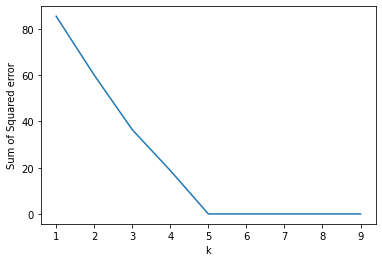

In [110]:
plt.xlabel('k')
plt.ylabel('Sum of Squared error')
plt.plot(k_rng,sse)

Run k-means to cluster the neighborhood into 5 clusters.

In [111]:
# set number of clusters
kclusters = 5

concat_grouped_clustering = concat_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(concat_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 4, 4, 4, 4, 3, 2, 1, 3], dtype=int32)

In [112]:
# add clustering labels
concat_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [113]:
concat_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Bentall Centre,Train Station,Supermarket,Mall,Gas Station,ATM
1,0,"Central Kitsilano, Greektown",Supermarket,ATM,Train Station,Mall,Gas Station
2,4,"East Fairview, South Cambie",Mall,Train Station,Gas Station,ATM,Supermarket
3,4,"N E Downtown, Gastown, Harbour Centre, Interna...",Gas Station,Mall,ATM,Train Station,Supermarket
4,4,"N W Shaughnessy, East Kitsilano, Quilchena",Mall,Gas Station,ATM,Train Station,Supermarket


Create a new dataframe that includes the cluster as well as the facilities for each neighborhood.

In [114]:
concat_merged = concat_dataframe[['name', 'categories', 'Latitude', 'Longitude',
       'Postal Code', 'city', 'Neighborhood']]

# merge concat_grouped with concat_venues_sorted to add latitude/longitude for each neighborhood
concat_merged = concat_merged.join(concat_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

concat_merged.head() # check the last columns!

,name,categories,Latitude,Longitude,Postal Code,city,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Yaletown - Roundhouse SkyTrain Station,Train Station,49.274531,-123.121993,V6B,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",4,Gas Station,Mall,ATM,Train Station,Supermarket
3,Stadium - Chinatown SkyTrain Station,Train Station,49.279267,-123.109447,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",1,Gas Station,Train Station,Supermarket,Mall,ATM
4,Main Street – Science World SkyTrain Station,Train Station,49.273079,-123.100360,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",1,Gas Station,Train Station,Supermarket,Mall,ATM
5,King Edward SkyTrain Station,Train Station,49.249120,-123.115703,V5Z,Vancouver,"East Fairview, South Cambie",4,Mall,Train Station,Gas Station,ATM,Supermarket
6,Commercial - Broadway SkyTrain Station,Train Station,49.262346,-123.069219,V5N,Vancouver,"South Grandview-Woodland, N E Kensington-Cedar...",0,Train Station,Supermarket,Gas Station,ATM,Mall


visualize on map

In [115]:
# create map
map_clusters = folium.Map(location=[49.2608724,-123.1139529], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(concat_merged['Latitude'], concat_merged['Longitude'], concat_merged['Neighborhood'], concat_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [116]:
concat_merged.loc[concat_merged['Cluster Labels'] == 0, concat_merged.columns[[1] + list(range(5, concat_merged.shape[1]))]].head()

,categories,city,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Train Station,Vancouver,"South Grandview-Woodland, N E Kensington-Cedar...",0,Train Station,Supermarket,Gas Station,ATM,Mall
15,Train Station,Vancouver,"S E Oakridge, East Marpole, South Sunset",0,Train Station,Supermarket,ATM,Mall,Gas Station
21,Train Station,Vancouver,"South Hastings-Sunrise, North Renfrew-Collingwood",0,Train Station,ATM,Supermarket,Mall,Gas Station
27,Train Station,Vancouver,"S E Oakridge, East Marpole, South Sunset",0,Train Station,Supermarket,ATM,Mall,Gas Station
30,Train Station,Vancouver,"South Hastings-Sunrise, North Renfrew-Collingwood",0,Train Station,ATM,Supermarket,Mall,Gas Station


### Cluster 2

In [117]:
concat_merged.loc[concat_merged['Cluster Labels'] == 1, concat_merged.columns[[1] + list(range(5, concat_merged.shape[1]))]].head()

,categories,city,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Train Station,Vancouver,"Strathcona, Chinatown, Downtown Eastside",1,Gas Station,Train Station,Supermarket,Mall,ATM
4,Train Station,Vancouver,"Strathcona, Chinatown, Downtown Eastside",1,Gas Station,Train Station,Supermarket,Mall,ATM
7,Train Station,Vancouver,Pacific Centre,1,Train Station,Gas Station,Supermarket,Mall,ATM
12,Train Station,Vancouver,South Renfrew-Collingwood,1,Train Station,Supermarket,Mall,Gas Station,ATM
14,Train Station,Vancouver,Bentall Centre,1,Train Station,Supermarket,Mall,Gas Station,ATM


### Cluster 3

In [118]:
concat_merged.loc[concat_merged['Cluster Labels'] == 2, concat_merged.columns[[1] + list(range(5, concat_merged.shape[1]))]].head()

,categories,city,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,ATM,Vancouver,North Hastings-Sunrise,2,ATM,Train Station,Supermarket,Mall,Gas Station
24,ATM,Vancouver,"South Shaughnessy, N W Oakridge, N E Kerrisdal...",2,ATM,Train Station,Supermarket,Mall,Gas Station


### Cluster 4

In [119]:
concat_merged.loc[concat_merged['Cluster Labels'] == 3, concat_merged.columns[[1] + list(range(5, concat_merged.shape[1]))]]

,categories,city,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
81,Gas Station,Vancouver,"West Kensington-Cedar Cottage, N E Riley Park-...",3,Supermarket,Gas Station,Train Station,Mall,ATM
109,Supermarket,Vancouver,"West Kensington-Cedar Cottage, N E Riley Park-...",3,Supermarket,Gas Station,Train Station,Mall,ATM
113,Supermarket,Vancouver,"West Kensington-Cedar Cottage, N E Riley Park-...",3,Supermarket,Gas Station,Train Station,Mall,ATM
116,Supermarket,Vancouver,"West Kensington-Cedar Cottage, N E Riley Park-...",3,Supermarket,Gas Station,Train Station,Mall,ATM
118,Supermarket,Vancouver,"West Kensington-Cedar Cottage, N E Riley Park-...",3,Supermarket,Gas Station,Train Station,Mall,ATM
121,Supermarket,Vancouver,North Grandview-Woodland,3,Supermarket,Train Station,Mall,Gas Station,ATM
122,Supermarket,Vancouver,"S E Kensington-Cedar Cottage, Victoria-Fraserview",3,Supermarket,Train Station,Mall,Gas Station,ATM
123,Supermarket,Vancouver,North Grandview-Woodland,3,Supermarket,Train Station,Mall,Gas Station,ATM
124,Supermarket,Vancouver,"S E Kensington-Cedar Cottage, Victoria-Fraserview",3,Supermarket,Train Station,Mall,Gas Station,ATM
125,Supermarket,Vancouver,"S E Kensington-Cedar Cottage, Victoria-Fraserview",3,Supermarket,Train Station,Mall,Gas Station,ATM


### Cluster 5

In [121]:
concat_merged.loc[concat_merged['Cluster Labels'] == 4, concat_merged.columns[[1] + list(range(5, concat_merged.shape[1]))]].head()

,categories,city,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Train Station,Vancouver,"N E Downtown, Gastown, Harbour Centre, Interna...",4,Gas Station,Mall,ATM,Train Station,Supermarket
5,Train Station,Vancouver,"East Fairview, South Cambie",4,Mall,Train Station,Gas Station,ATM,Supermarket
8,Train Station,Vancouver,"East Fairview, South Cambie",4,Mall,Train Station,Gas Station,ATM,Supermarket
9,Train Station,Vancouver,"Waterfront, Coal Harbour, Canada Place",4,Train Station,Gas Station,Mall,ATM,Supermarket
36,Train Station,Vancouver,"Waterfront, Coal Harbour, Canada Place",4,Train Station,Gas Station,Mall,ATM,Supermarket


## Discussion 

From the data analysis and visualization, we can see that ATMs are usually located near shopping malls, train stations, gas stations and supermarkets, which inspired us to find out the areas with more footfall traffic and fewer ATMs.

After the K-Means Clustering machine learning algorithm, we got the clusters with the most footfall traffic and fewer ATMs on average. For more accurate guidance, the data set used can be expanded and the details of the neighbourhood such as population census data, crime data, etc can also be drilled in.


#### Conclusion

The purpose of this project was to explore areas in Vancouver and their respective distribution of ATM facilities and also find areas to install these ATMs.

After wrangling data from several data sources and cleaning them to obtain clean datasets, applying the K-Means clustering algorithm, we picked the clusters with more footfall traffic and fewer ATMs on average. Clusters 4 and 5 showed that ATMs were the least common venue/facility in those neighbourhoods. This could be used as a starting point for final exploration by financial institutions wishing to expand their services.

Of course, the final decision on optimal ATM location will be made by the stakeholders based on specific characteristics of neighbourhoods, taking into consideration additional factors like the crime rate in the area, population distribution, etc.


## References:

•	Developer | Foursquare

•	List of postal codes of Canada: V - Wikipedia

•	Welcome to GeoPy’s documentation! — GeoPy 2.1.0 documentation

•	istanbul/Istanbul.ipynb at master · Srcanyildiz/istanbul (github.com)
